In [1]:
import numpy as np
import matplotlib.pyplot as plt

# I. Linear models

In [2]:
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])

    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")

    plt.legend()
    plt.show()

In [3]:
# Hyperparameters for linear model
SIG = 0.2
ALPHA = 2.0
NB_POINTS =25
BETA = 1/(2.0*SIG**2)

Let's generate our toy dataset

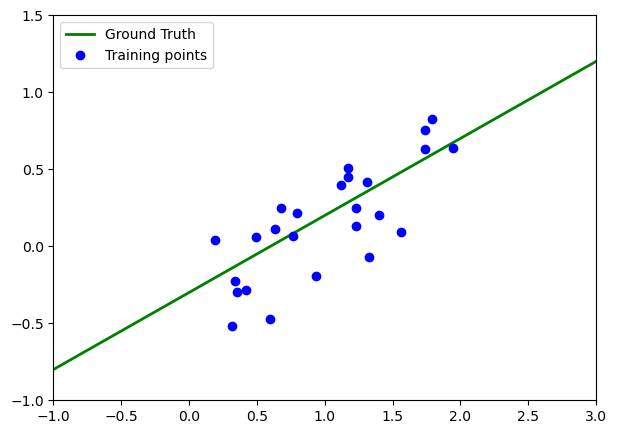

In [4]:
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, NB_POINTS)
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=SIG)
dataset_linear['X_test'] = np.linspace(-10,10, 10*NB_POINTS)
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=SIG)
dataset_linear['ALPHA'] = ALPHA
dataset_linear['BETA'] = 1/(2.0*SIG**2)

plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

C:\Users\natha\AppData\Local\Temp\ipykernel_17320\55053491.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior[i, j] = np.exp(-0.5 * np.dot(np.dot((w - mu.reshape(2,1)).T, sigmainv), (w - mu.reshape(2,1))))


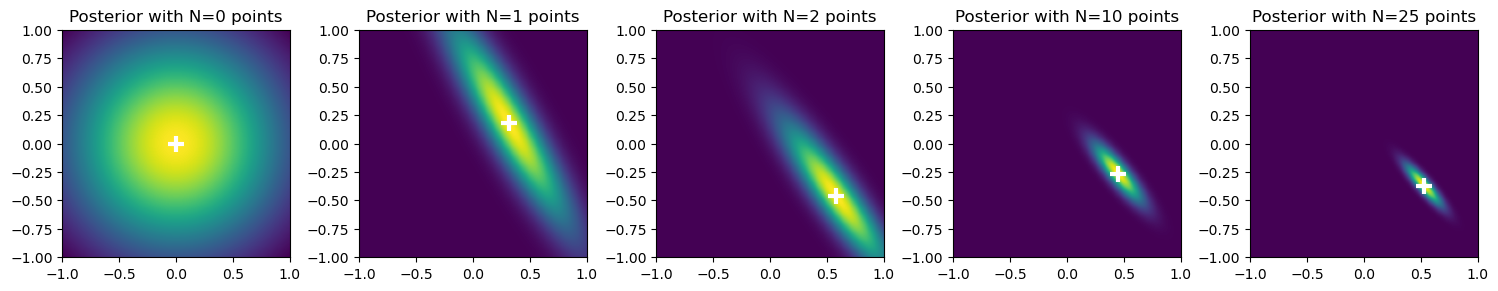

In [5]:
#Define the linear basis function
phi_linear = lambda x: np.array([1, x])

# Compute mu and sigma to visualize posterior sampling
ALPHA = dataset_linear['ALPHA']
BETA = dataset_linear['BETA']

plt.figure(figsize=(15,7))
for count, n in enumerate([0, 1, 2, 10, len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]
    meshgrid = np.arange(-1, 1.01, 0.01)
    w = np.zeros((2,1))
    posterior = np.zeros((meshgrid.shape[0], meshgrid.shape[0]))

    # Compute Phi
    Phi = np.array([phi_linear(x) for x in cur_data])

    # Compute Sigma and mu (Special case for n=0 handled automatically)
    Sigma_inv = ALPHA * np.eye(2) + BETA * np.dot(Phi.T, Phi)
    Sigma = np.linalg.inv(Sigma_inv)
    if n > 0:
        mu = BETA * np.dot(np.dot(Sigma, Phi.T), cur_lbl)
    else:
        mu = np.zeros(2)  # Prior mean

    Sigma_det = np.linalg.det(Sigma)
    sigmainv = np.linalg.inv(Sigma)

    # Compute values on meshgrid
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0, 0] = meshgrid[i]
            w[1, 0] = meshgrid[j]
            posterior[i, j] = np.exp(-0.5 * np.dot(np.dot((w - mu.reshape(2,1)).T, sigmainv), (w - mu.reshape(2,1))))

    Z = 1.0 / (np.sqrt((2 * np.pi) ** 2 * Sigma_det))
    posterior[:, :] /= Z

    plt.subplot(151 + count)
    plt.imshow(posterior, extent=[-1, 1, -1, 1], origin='lower')
    plt.plot(mu[1], mu[0], '+', markeredgecolor='white', markeredgewidth=3, markersize=12)  # mu[1] is x, mu[0] is bias
    plt.title(f'Posterior with N={n} points')

plt.tight_layout()
plt.show()

In [6]:
def closed_form(func, X_train, y_train, alpha, beta):
    Phi = np.array([func(x) for x in X_train])

    # Compute S and mu for the posterior distribution
    S_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T @ Phi
    S = np.linalg.inv(S_inv)
    mu = beta * (S @ Phi.T @ y_train)

    def f_model(x):
        phi_x = np.array(func(x)).reshape(-1, 1)

        mean = mu.T @ phi_x
        sigma = 1/beta + phi_x.T @ S @ phi_x

        return mean.item(), np.sqrt(sigma.item())

    return f_model

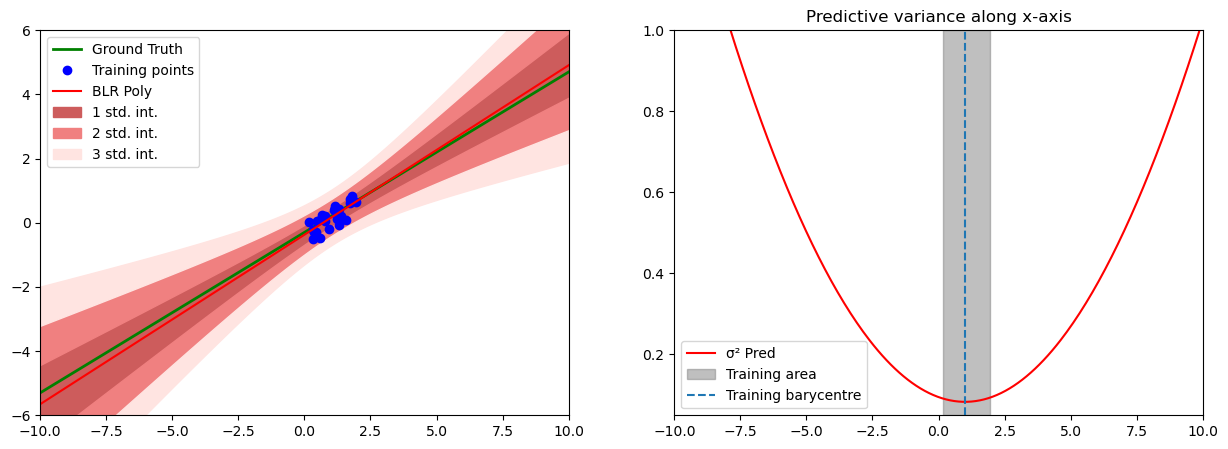

In [7]:
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'],
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

# Predict test points
y_pred = []
std_pred = []
for x in dataset_linear['X_test']:
    mean, std = f_pred(x)
    y_pred.append(mean)
    std_pred.append(std)

y_pred = np.array(y_pred)
std_pred = np.array(std_pred)

plot_results(dataset_linear['X_train'], dataset_linear['y_train'],
             dataset_linear['X_test'], dataset_linear['y_test'],
             y_pred, std_pred, xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1)

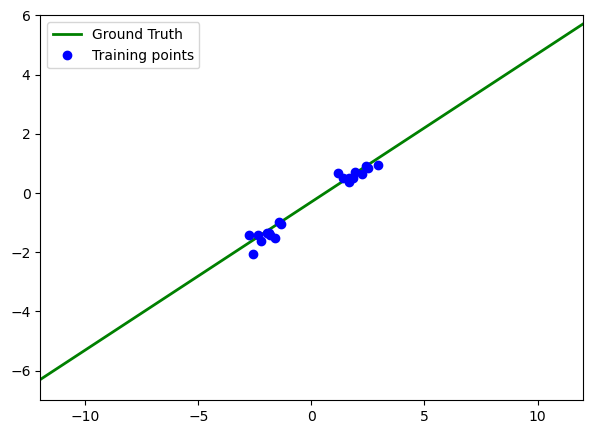

In [8]:
# Create new training and test points with two blocks of points with a hole separating them
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=SIG)
dataset_hole['X_test'] = np.linspace(-12,12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0,sigma=SIG)
dataset_hole['ALPHA'] = ALPHA
dataset_hole['BETA'] = BETA

plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

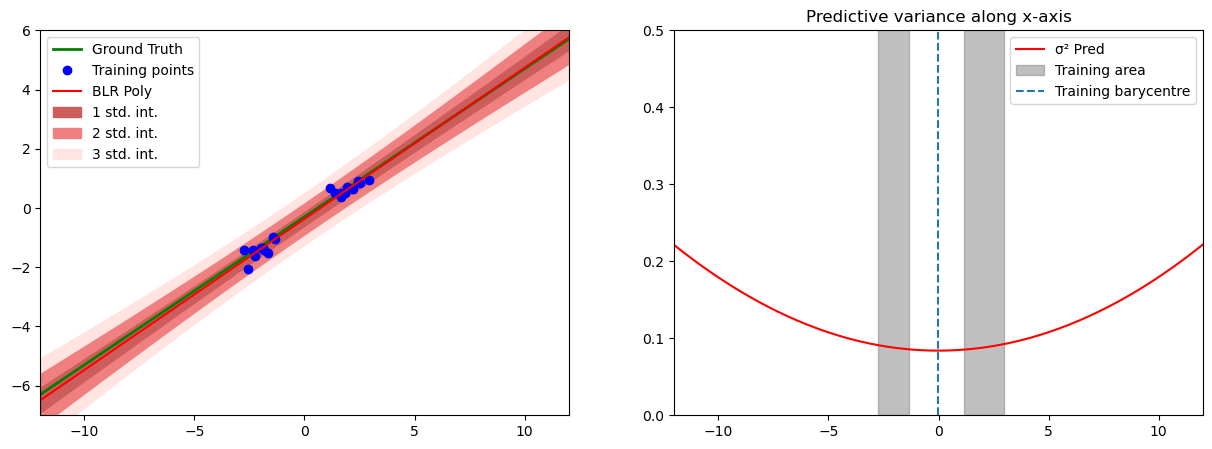

In [9]:
f_pred_hole = closed_form(phi_linear, dataset_hole['X_train'], dataset_hole['y_train'],
                          dataset_hole['ALPHA'], dataset_hole['BETA'])

y_pred_hole = []
std_pred_hole = []
for x in dataset_hole['X_test']:
    mean, std = f_pred_hole(x)
    y_pred_hole.append(mean)
    std_pred_hole.append(std)

y_pred_hole = np.array(y_pred_hole)
std_pred_hole = np.array(std_pred_hole)

plot_results(dataset_hole['X_train'], dataset_hole['y_train'], dataset_hole['X_test'],
             dataset_hole['y_test'], y_pred_hole, std_pred_hole,
             xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5)

# II. Non linear models 

In [ ]:
NB_POLYNOMIAL_FEATURES = 10
SIG = 0.2
ALPHA = 0.05
NB_POINTS = 50
NB_POLYNOMIAL_FEATURES = 10

Let's begin with polynomial basis functions

In [14]:
def phi_polynomial(x, degree=NB_POLYNOMIAL_FEATURES):
    return np.array([x**i for i in range(degree)])

Let's now generate a sinuoidal toy dataset

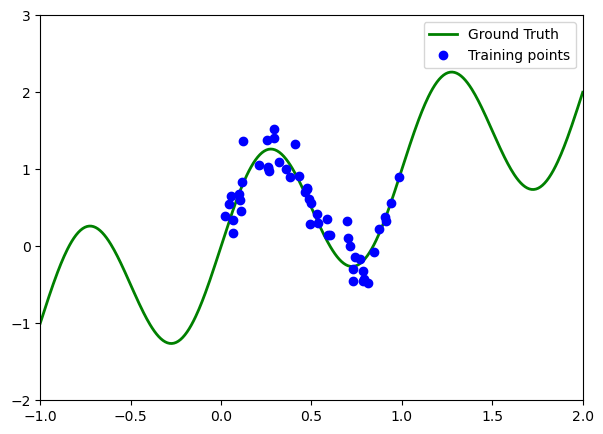

In [11]:
def f_sinus(x, noise_amount,sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, NB_POINTS)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1,sigma=SIG)
dataset_sinus['X_test'] = np.linspace(-1,2, 10*NB_POINTS)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0,sigma=SIG)
dataset_sinus['ALPHA'] = ALPHA
dataset_sinus['BETA'] = 1/(2.0*SIG**2)

plt.figure(figsize=(7,5))
plt.xlim(xmin =-1, xmax = 2)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [12]:
# Define the closed_form function for polynomial features

def closed_form_polynomial(X_train, y_train, alpha, beta, degree=NB_POLYNOMIAL_FEATURES):
    Phi = np.array([phi_polynomial(x, degree) for x in X_train])
    S_inv = alpha * np.eye(degree) + beta * Phi.T @ Phi
    S = np.linalg.inv(S_inv)
    mu = beta * S @ Phi.T @ y_train

    def f_model(x):
        phi_x = phi_polynomial(x, degree).reshape(-1, 1)
        mean = mu.T @ phi_x
        sigma = 1 / beta + phi_x.T @ S @ phi_x
        return mean.item(), np.sqrt(sigma.item())

    return f_model

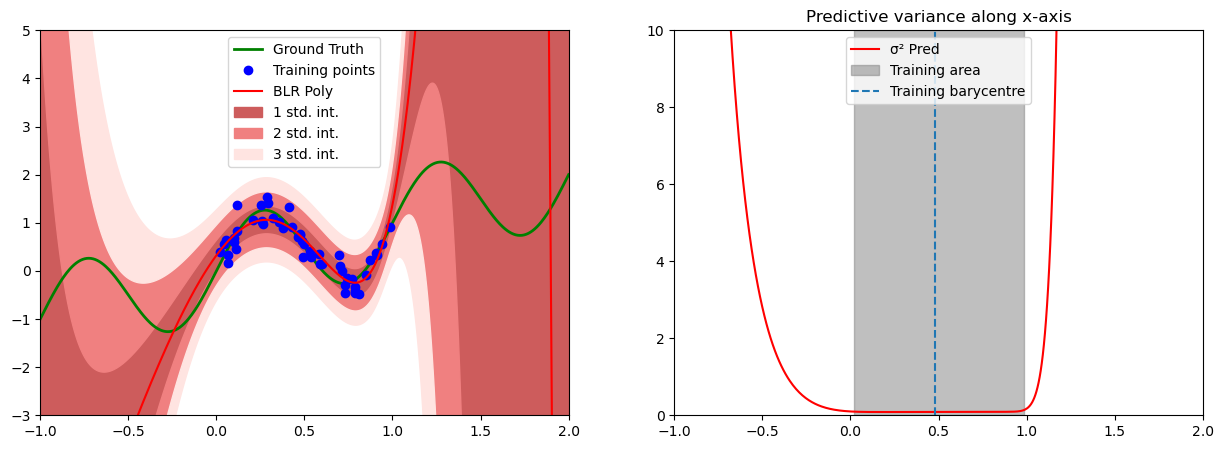

In [13]:
f_pred_poly = closed_form_polynomial(dataset_sinus['X_train'], dataset_sinus['y_train'],
                                     dataset_sinus['ALPHA'], dataset_sinus['BETA'],
                                     degree=NB_POLYNOMIAL_FEATURES)

y_pred_poly = []
std_pred_poly = []
for x in dataset_sinus['X_test']:
    mean, std = f_pred_poly(x)
    y_pred_poly.append(mean)
    std_pred_poly.append(std)

y_pred_poly = np.array(y_pred_poly)
std_pred_poly = np.array(std_pred_poly)

plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], dataset_sinus['X_test'],
             dataset_sinus['y_test'], y_pred_poly, std_pred_poly,
             xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10)

Now let's try Gaussian basis functions

In [15]:
MU_MIN = 0
MU_MAX = 1
NB_GAUSSIAN_FEATURES = 9 

def phi_gaussian(x, MU_MIN=MU_MIN, MU_MAX=MU_MAX, NB_GAUSSIAN_FEATURES=NB_GAUSSIAN_FEATURES):
    mus = np.linspace(MU_MIN, MU_MAX, NB_GAUSSIAN_FEATURES)
    s = (MU_MAX - MU_MIN) / NB_GAUSSIAN_FEATURES

    return np.exp(-0.5 * ((x - mus) ** 2) / s ** 2)

In [16]:
def closed_form_gaussian(X_train, y_train, alpha, beta, MU_MIN, MU_MAX, NB_GAUSSIAN_FEATURES):
    Phi = np.array([phi_gaussian(x, MU_MIN, MU_MAX, NB_GAUSSIAN_FEATURES) for x in X_train])
    S_inv = alpha * np.eye(NB_GAUSSIAN_FEATURES) + beta * Phi.T @ Phi
    S = np.linalg.inv(S_inv)
    mu = beta * S @ Phi.T @ y_train

    def f_model(x):
        phi_x = phi_gaussian(x, MU_MIN, MU_MAX, NB_GAUSSIAN_FEATURES).reshape(-1, 1)
        mean = mu.T @ phi_x
        sigma = 1 / beta + phi_x.T @ S @ phi_x
        return mean.item(), np.sqrt(sigma.item())

    return f_model

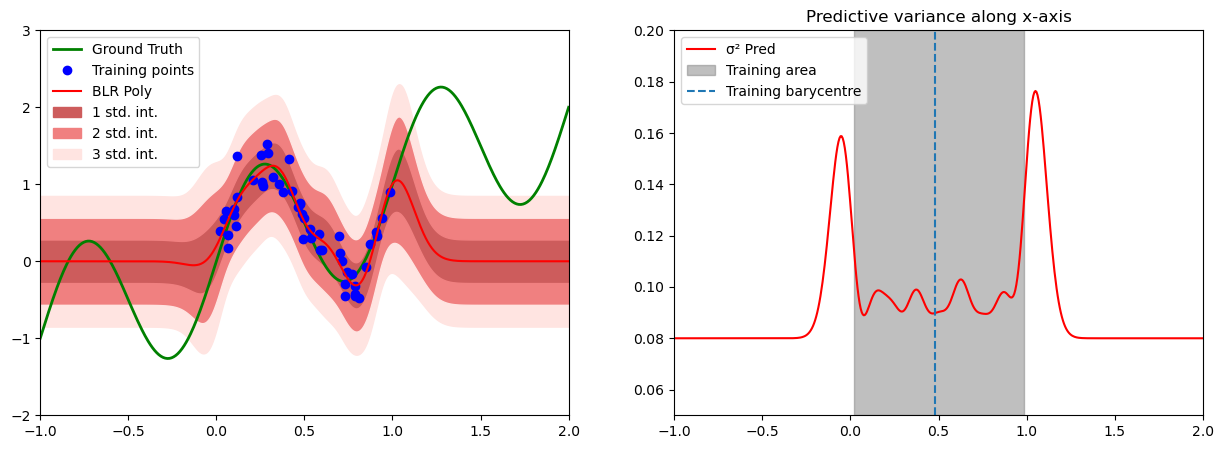

In [17]:
f_pred_gauss = closed_form_gaussian(dataset_sinus['X_train'], dataset_sinus['y_train'],
                                    dataset_sinus['ALPHA'], dataset_sinus['BETA'],
                                    MU_MIN, MU_MAX, NB_GAUSSIAN_FEATURES)

y_pred_gauss = []
std_pred_gauss = []
for x in dataset_sinus['X_test']:
    mean, std = f_pred_gauss(x)
    y_pred_gauss.append(mean)
    std_pred_gauss.append(std)

y_pred_gauss = np.array(y_pred_gauss)
std_pred_gauss = np.array(std_pred_gauss)

plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], dataset_sinus['X_test'],
             dataset_sinus['y_test'], y_pred_gauss, std_pred_gauss,
             xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2)